In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numba as nb
import pandas_ta as ta
import os
import datetime
import json
from tabulate import tabulate
import sys
sys.path.append('../..')
import vectorbtpro as vbt
from vectorbtpro.portfolio.enums import SizeType
from src.utils import fu
from src.utils import plot_return_mdd
from src.strategy.BackTester import BackTester
from src.strategy.Analyzer import Analyzer
from src.strategy.MultiTester import MultiTester
from src.utils import plot_return_mdd,twinx_plot # as utils
from bband import get_data,Strategy

### 樣本內全參數 (多、空)

In [7]:
import ast
import pandas as pd
import hiplot as hip

def insample_params_highland(coin:str, freq: str, direction: str):
    params_df = pd.read_csv(f'opt/{freq}/{coin}/{direction}_record_df.csv').drop(columns=['Unnamed: 0'])
    params_df['params'] = params_df['params'].apply(ast.literal_eval)
    temp_df = params_df['params'].apply(pd.Series)
    df = pd.concat([params_df.drop(columns='params'), temp_df], axis=1)
    target = df[['window_l_k','window_l_d','window_s_k','window_s_d','Sharpe Ratio','Calmar Ratio','Win Rate [%]']]
    data_for_hiplot = target.to_dict(orient='records')
    exp = hip.Experiment.from_iterable(data_for_hiplot)
    exp.display(force_full_width=False, width=400, height=100)


In [3]:
symbol_list = ['ETH','BTC','BNB','SOL','MATIC',
               'XRP','DYDX','AVAX','LINK','GAS',
               'DOGE','ORDI','TRB','WLD','ADA',
               'OP','FIL','ZRX','LTC','RUNE','ATOM',
               'ARB','GMT','ETC','ARK','BCH','DOT',
               '1000PEPE','LDO','SUI','GALA','CAKE',
               'APE','INJ','FTM','APT','YFI','OMG',
               'SEI','EOS','1000SHIB','NEAR','STORJ',
               '1000FLOKI','MKR','CYBER','UNI','STRAX',
               'BLUR','SUSHI','WAVES','MASK','MANA',
               'EGLD','AAVE','NEO','FET','TRX','GRT','ALGO','STX','XLM']

insample_long_dict = {}
insample_short_dict = {}
for freq in ['5T','15T','1h','4h']:
    insample_long_dict[freq] = []
    insample_short_dict[freq] = []
    for coin in symbol_list:
        for direction in ['long','short']:
            try:
                params_df = pd.read_csv(f'opt/{freq}/{coin}/{direction}_record_df.csv').drop(columns=['Unnamed: 0'])
                if params_df['Sharpe Ratio'].iloc[0] > 2:
                    if direction == 'long':
                        insample_long_dict[freq].append(coin)
                    else:
                        insample_short_dict[freq].append(coin)
            except:
                pass


### 樣本外
取樣本內前一半參數來看樣本外表現


In [4]:
df_dict = {}
candidate = ['ETH','BTC','BNB','SOL','MATIC',
               'XRP','DYDX','AVAX','LINK','GAS',
               'DOGE','ORDI','TRB','WLD','ADA',
               'OP','FIL','ZRX','LTC','RUNE','ATOM',
               'ARB','GMT','ETC','ARK','BCH','DOT',
               'LDO','SUI','GALA','CAKE',
               'APE','INJ','FTM','APT','YFI','OMG',
               'SEI','EOS','1000SHIB','NEAR',
               'MKR','CYBER','UNI',
               'BLUR','SUSHI','WAVES','MASK','MANA',
               'EGLD','AAVE','NEO','FET','TRX','GRT','ALGO','STX','XLM']
for coin in candidate:
    df_dict[coin] = pd.read_hdf(f'/Users/johnsonhsiao/Desktop/data/{coin}USDT_PERPETUAL.h5')

In [10]:
from tqdm.auto import tqdm
start = '2022-01-01'
sep = ''
end = ''

def outample_params_highland(freq, side, coin):
    outsample_record = []
    params_df = pd.read_csv(f'/Users/johnsonhsiao/DC_capital_intern/strategy_research/CTA_TEST/Crypto/bband/opt/{freq}/{coin}/{direction}_record_df.csv')
    for idx , row in tqdm(params_df[:int(len(params_df)/2)].iterrows(), total=int(len(params_df)/2), desc="Processing"):
        params = eval(row['params'])
        config = {'freq':freq, 'lag':1, 'fee': 0.0003, 'weekend_filter': False}
        df = df_dict[coin]
        strategy = Strategy(df=df.loc[start:], configs=config)
        analyze = Analyzer(strategy)
        mdd, stat = analyze.outsample_result_gen(params, side, coin, axv_index=['2023-05-01'])
        params['mdd'] = mdd
        params['sharpe'] = stat['Sharpe Ratio']
        params['calmar'] = stat['Calmar Ratio']
        params['win rate'] = stat['Win Rate [%]']
        outsample_record.append(params)
    exp = hip.Experiment.from_iterable(outsample_record)
    exp.display()


In [5]:
def in_out_test(freq, coin, direction):
        outsample_record = []
        params_df = pd.read_csv(f'/Users/johnsonhsiao/DC_capital_intern/strategy_research/CTA_TEST/Crypto/bband/opt/{freq}/{coin}/{direction}_record_df.csv')
        for idx , row in tqdm(params_df[:int(len(params_df)/2)].iterrows(), total=int(len(params_df)/2), desc="Processing"):
            params = eval(row['params'])
            config = {'freq':freq, 'lag':1, 'fee': 0.0003, 'weekend_filter': False}
            try:
                df = df_dict[coin]
            except:
                df_dict[coin] = pd.read_hdf(f'/Volumes/crypto_data/price_data/binance/1m/{coin}USDT_PERPETUAL.h5')
                df = df_dict[coin]            
            strategy = Strategy(df=df.loc[start:], configs=config)
            analyze = Analyzer(strategy)
            mdd, stat = analyze.outsample_result_gen(params, direction, coin, axv_index=['2023-05-01'])
            params['mdd'] = mdd
            params['sharpe'] = stat['Sharpe Ratio']
            params['calmar'] = stat['Calmar Ratio']
            params['win rate'] = stat['Win Rate [%]']
            outsample_record.append(params)
        max_sharpe = 0
        for i in range(len(outsample_record)):
            if outsample_record[i]['sharpe'] > max_sharpe:
                max_sharpe = outsample_record[i]['sharpe']
                best_params = outsample_record[i]
        if max_sharpe > 2:
            print(best_params)
            strategy = Strategy(df=df.loc[start:], configs=config)
            _pf = strategy.strategy(side = direction,params=params)
            analyze = Analyzer(strategy)
            analyze.show_pf_analysis(dict(list(best_params.items())[:2]), direction, coin, axv_index=['2023-05-01'])

ARB 5T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

APT 5T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

BLUR 5T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

FET 5T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

STX 5T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

DYDX 15T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

LINK 15T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

OP 15T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

ARB 15T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

GMT 15T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

APT 15T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

BLUR 15T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

FET 15T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

STX 15T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

DYDX 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

{'window_size': 396, 'multiplier': 2.5, 'mdd': 27.54, 'sharpe': 2.2603932978365413, 'calmar': 3.8876522643983638, 'win rate': 26.881720430107524}
APY: 59.63 %
MDD: 12.72 %
MDD Duration 245 days 04:00:00
worst trade: -8.54 %
2022-06-22 10:00:00 ~ 2022-06-22 13:00:00
avg holding days: 0.67 days
--------------------------------------------
PF: 2.36
Sharpe Ratio: 2.26
Calmar Ratio: 3.89
Sortino Ratio: 4.05
Omega Ratio: 1.30
--------------------------------------------
Expectancy : 1.19 %
Total Time Exposure : 9.23 %
Total Trades: 93
Win Rate: 26.88 %
--------------------------------------------
PF * Win Rate: 0.634


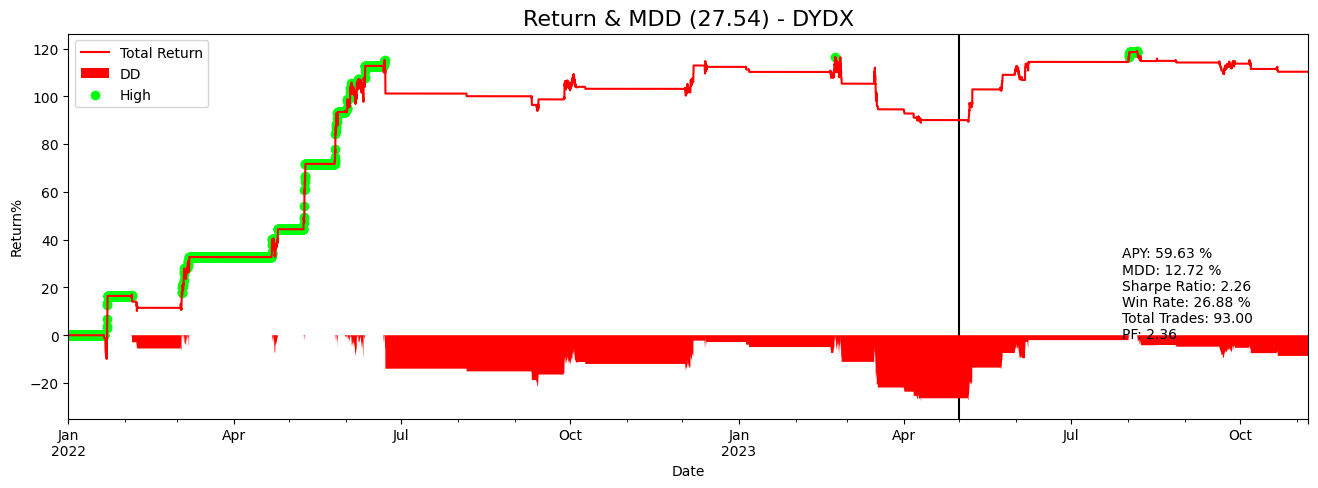

AVAX 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

OP 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

RUNE 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

{'window_size': 48, 'multiplier': 2.5, 'mdd': 15.98, 'sharpe': 2.5018472152880418, 'calmar': 5.238298028672589, 'win rate': 37.22627737226277}
APY: 59.27 %
MDD: 9.32 %
MDD Duration 175 days 03:00:00
worst trade: -4.29 %
2022-03-31 13:00:00 ~ 2022-03-31 14:00:00
avg holding days: 0.20 days
--------------------------------------------
PF: 1.64
Sharpe Ratio: 2.50
Calmar Ratio: 5.24
Sortino Ratio: 4.17
Omega Ratio: 1.33
--------------------------------------------
Expectancy : 0.41 %
Total Time Exposure : 7.78 %
Total Trades: 274
Win Rate: 37.23 %
--------------------------------------------
PF * Win Rate: 0.610


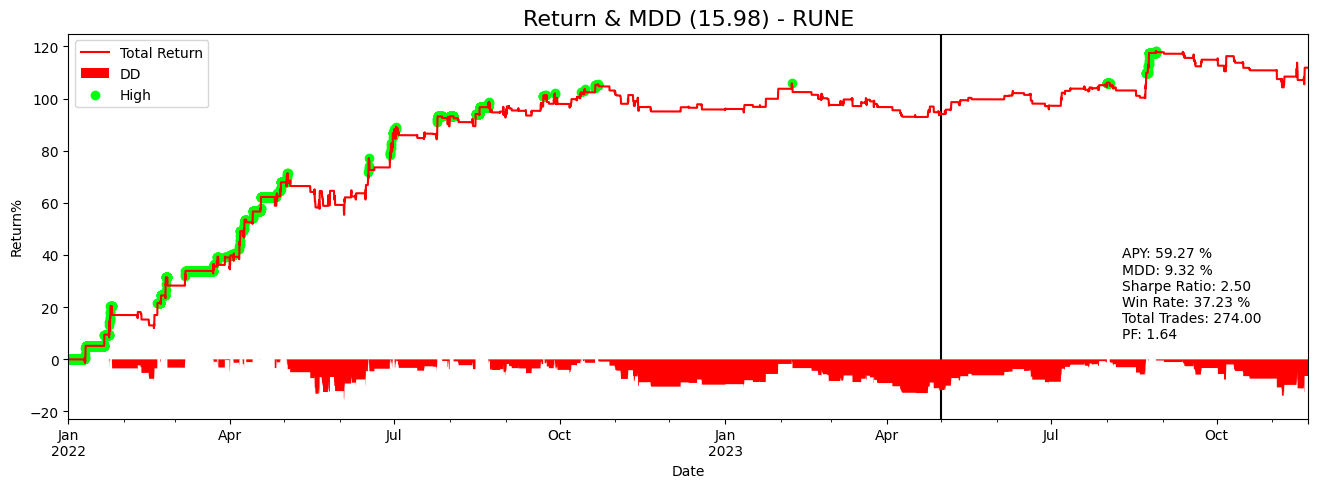

ARB 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

{'window_size': 244, 'multiplier': 2.0, 'mdd': 6.57, 'sharpe': 2.2048794028284666, 'calmar': 7.892984466805843, 'win rate': 47.22222222222222}
APY: 41.42 %
MDD: 5.59 %
MDD Duration 100 days 15:00:00
worst trade: -1.37 %
2023-05-18 17:00:00 ~ 2023-05-18 19:00:00
avg holding days: 0.63 days
--------------------------------------------
PF: 3.12
Sharpe Ratio: 2.20
Calmar Ratio: 7.89
Sortino Ratio: 3.96
Omega Ratio: 1.28
--------------------------------------------
Expectancy : 0.76 %
Total Time Exposure : 9.42 %
Total Trades: 36
Win Rate: 47.22 %
--------------------------------------------
PF * Win Rate: 1.473


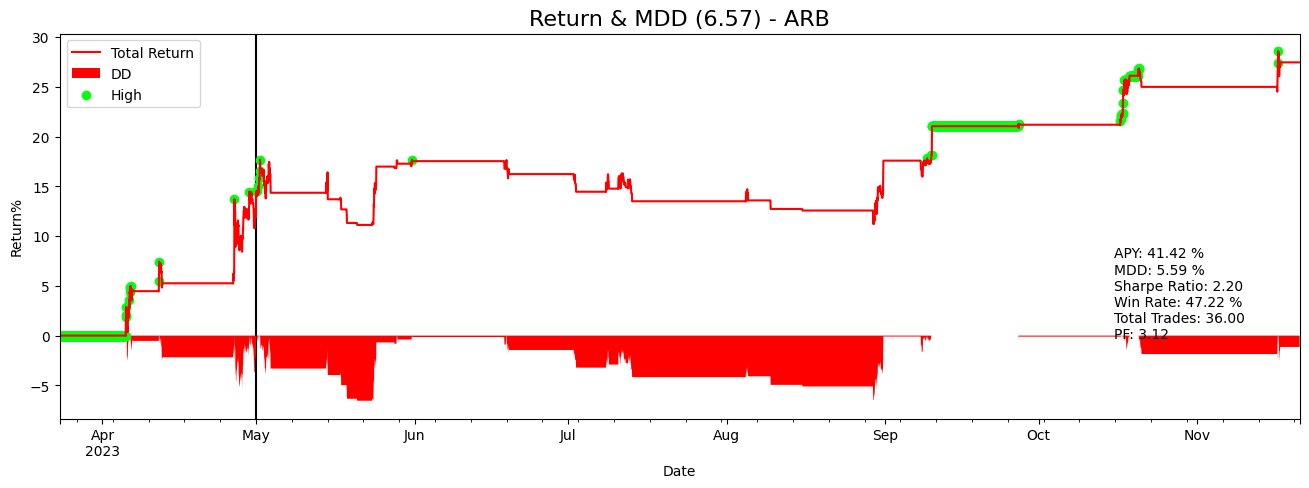

GMT 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

ETC 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

LDO 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

GALA 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

APE 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

APT 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

EOS 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

NEAR 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

BLUR 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

WAVES 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

NEO 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

FET 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

GRT 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

STX 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

{'window_size': 136, 'multiplier': 2.5, 'mdd': 8.84, 'sharpe': 2.834241494393086, 'calmar': 12.508569660426687, 'win rate': 39.34426229508197}
APY: 76.27 %
MDD: 6.61 %
MDD Duration 55 days 09:00:00
worst trade: -5.47 %
2023-03-30 00:00:00 ~ 2023-03-30 02:00:00
avg holding days: 0.39 days
--------------------------------------------
PF: 2.58
Sharpe Ratio: 2.83
Calmar Ratio: 12.51
Sortino Ratio: 5.37
Omega Ratio: 1.44
--------------------------------------------
Expectancy : 0.93 %
Total Time Exposure : 8.82 %
Total Trades: 61
Win Rate: 39.34 %
--------------------------------------------
PF * Win Rate: 1.015


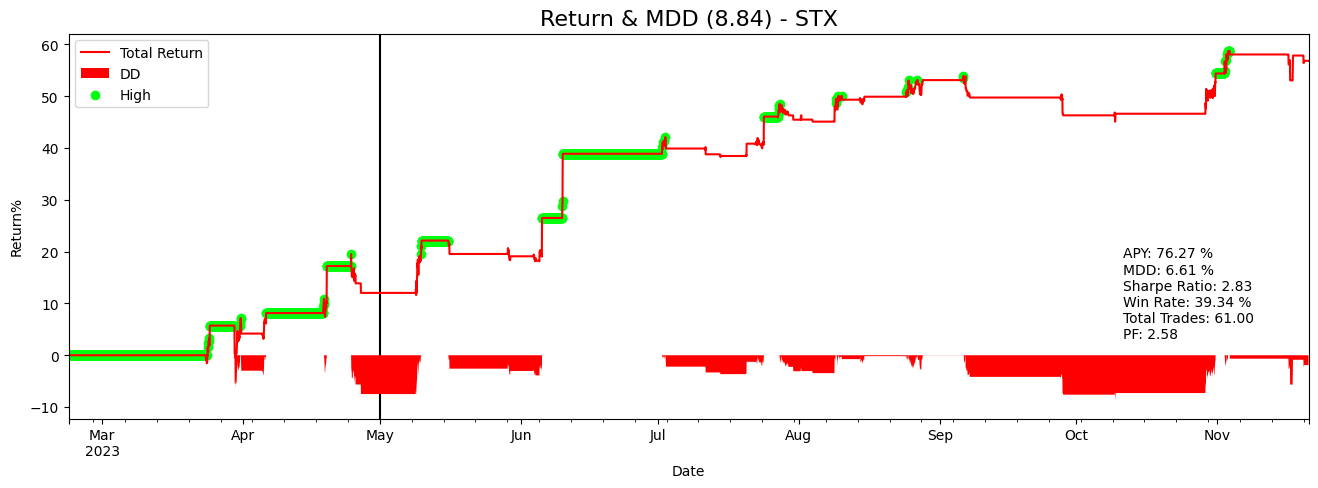

BTC 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

OP 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

ARB 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

GMT 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

LDO 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

INJ 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

APT 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

SUSHI 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

FET 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

GRT 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

STX 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

{'window_size': 152, 'multiplier': 2.0, 'mdd': 15.04, 'sharpe': 2.786409899159954, 'calmar': 8.099956587387926, 'win rate': 38.88888888888889}
APY: 88.86 %
MDD: 12.03 %
MDD Duration 66 days 16:00:00
worst trade: -3.43 %
2023-05-04 04:00:00 ~ 2023-05-08 08:00:00
avg holding days: 2.49 days
--------------------------------------------
PF: 4.49
Sharpe Ratio: 2.79
Calmar Ratio: 8.10
Sortino Ratio: 5.02
Omega Ratio: 1.65
--------------------------------------------
Expectancy : 3.68 %
Total Time Exposure : 16.44 %
Total Trades: 18
Win Rate: 38.89 %
--------------------------------------------
PF * Win Rate: 1.746


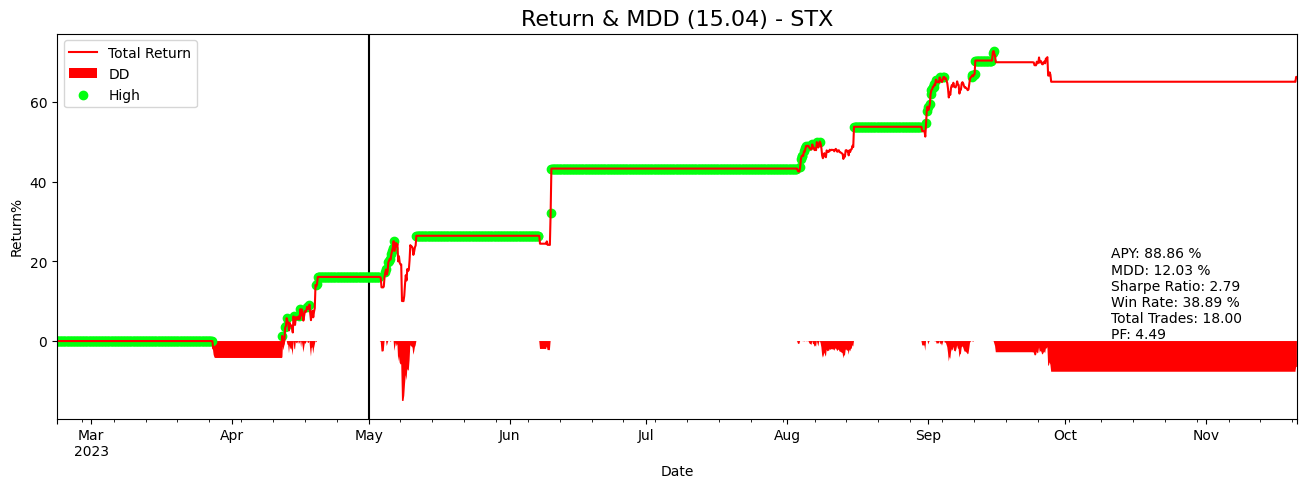

In [18]:
for freq in insample_short_dict.keys():
    for coin in insample_long_dict[freq]:
        print(coin, freq)
        in_out_test(freq,coin,'short')

ARB 5T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

APT 5T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

BLUR 5T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

FET 5T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

STX 5T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

DYDX 15T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

LINK 15T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

OP 15T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

ARB 15T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

{'window_size': 388, 'multiplier': 2.0, 'mdd': 33.96, 'sharpe': 2.0309747117594243, 'calmar': 2.5575534021720636, 'win rate': 15.555555555555555}
APY: 50.43 %
MDD: 21.27 %
MDD Duration 151 days 22:15:00
worst trade: -4.36 %
2023-06-30 11:45:00 ~ 2023-06-30 13:30:00
avg holding days: 0.12 days
--------------------------------------------
PF: 1.50
Sharpe Ratio: 2.03
Calmar Ratio: 2.56
Sortino Ratio: 3.28
Omega Ratio: 1.13
--------------------------------------------
Expectancy : 0.19 %
Total Time Exposure : 8.67 %
Total Trades: 180
Win Rate: 15.56 %
--------------------------------------------
PF * Win Rate: 0.233


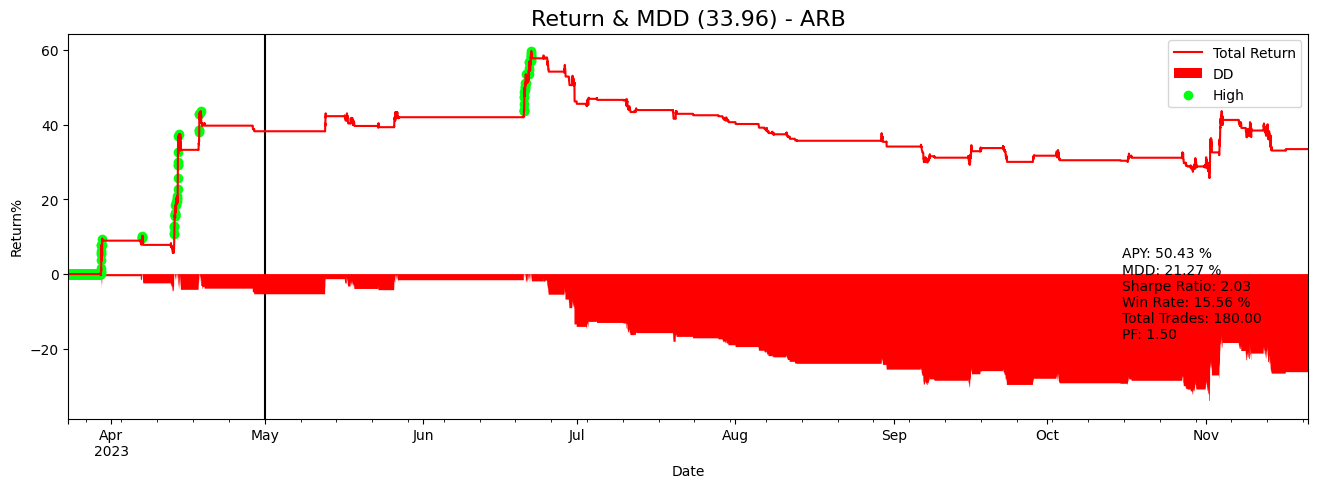

GMT 15T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

{'window_size': 392, 'multiplier': 2.5, 'mdd': 23.4, 'sharpe': 2.449003151748761, 'calmar': 5.768475023399831, 'win rate': 22.11764705882353}
APY: 94.30 %
MDD: 13.13 %
MDD Duration 126 days 17:30:00
worst trade: -3.56 %
2023-05-22 12:00:00 ~ 2023-05-22 12:30:00
avg holding days: 0.15 days
--------------------------------------------
PF: 1.79
Sharpe Ratio: 2.45
Calmar Ratio: 5.77
Sortino Ratio: 4.11
Omega Ratio: 1.17
--------------------------------------------
Expectancy : 0.37 %
Total Time Exposure : 10.38 %
Total Trades: 426
Win Rate: 22.12 %
--------------------------------------------
PF * Win Rate: 0.396


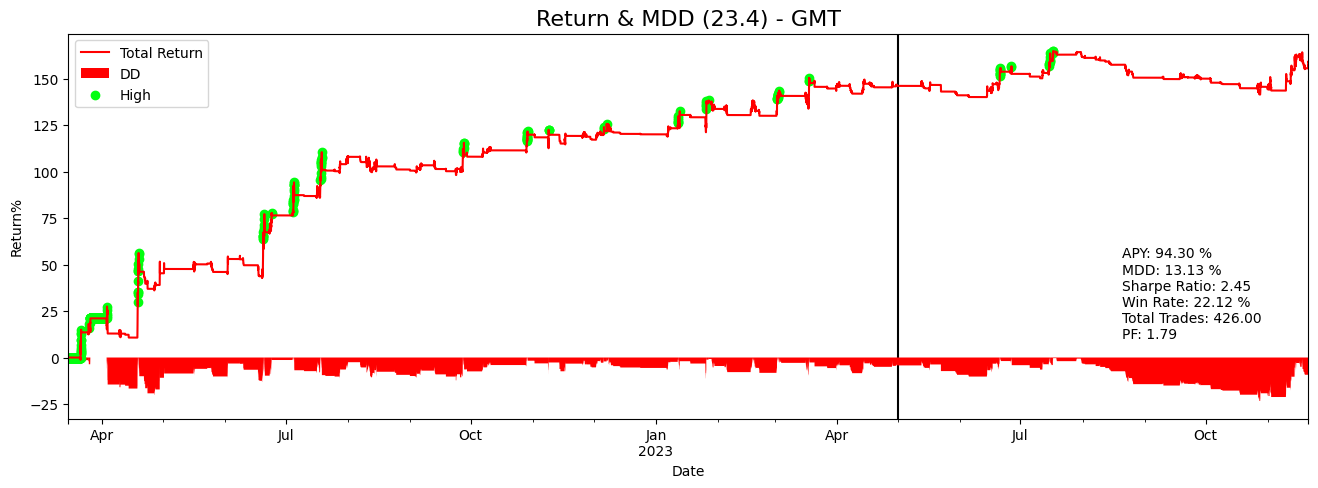

APT 15T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

{'window_size': 380, 'multiplier': 2.5, 'mdd': 16.75, 'sharpe': 2.1387240164044385, 'calmar': 8.716939452898515, 'win rate': 20.704845814977972}
APY: 85.58 %
MDD: 9.50 %
MDD Duration 113 days 22:45:00
worst trade: -3.71 %
2023-01-18 20:45:00 ~ 2023-01-18 23:30:00
avg holding days: 0.15 days
--------------------------------------------
PF: 1.97
Sharpe Ratio: 2.14
Calmar Ratio: 8.72
Sortino Ratio: 3.88
Omega Ratio: 1.17
--------------------------------------------
Expectancy : 0.41 %
Total Time Exposure : 8.67 %
Total Trades: 227
Win Rate: 20.70 %
--------------------------------------------
PF * Win Rate: 0.409


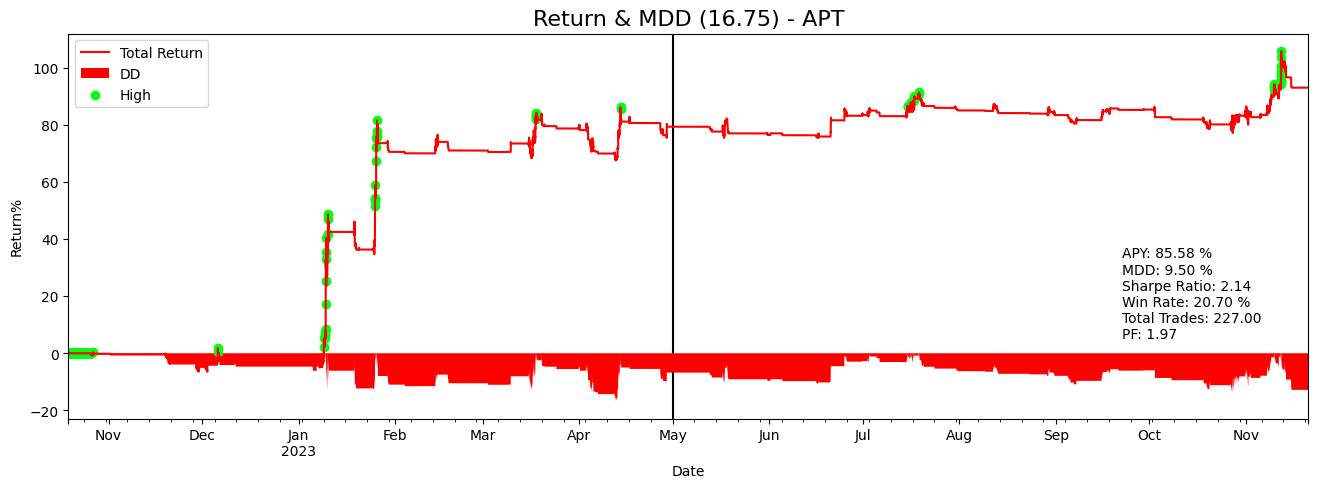

BLUR 15T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

FET 15T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

STX 15T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

DYDX 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

AVAX 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

OP 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

{'window_size': 128, 'multiplier': 2.5, 'mdd': 25.96, 'sharpe': 2.2370728748329385, 'calmar': 6.97180899808627, 'win rate': 23.96694214876033}
APY: 105.70 %
MDD: 12.78 %
MDD Duration 140 days 12:00:00
worst trade: -8.21 %
2022-09-12 17:00:00 ~ 2022-09-13 12:00:00
avg holding days: 0.35 days
--------------------------------------------
PF: 2.33
Sharpe Ratio: 2.24
Calmar Ratio: 6.97
Sortino Ratio: 4.71
Omega Ratio: 1.41
--------------------------------------------
Expectancy : 1.29 %
Total Time Exposure : 7.79 %
Total Trades: 121
Win Rate: 23.97 %
--------------------------------------------
PF * Win Rate: 0.559


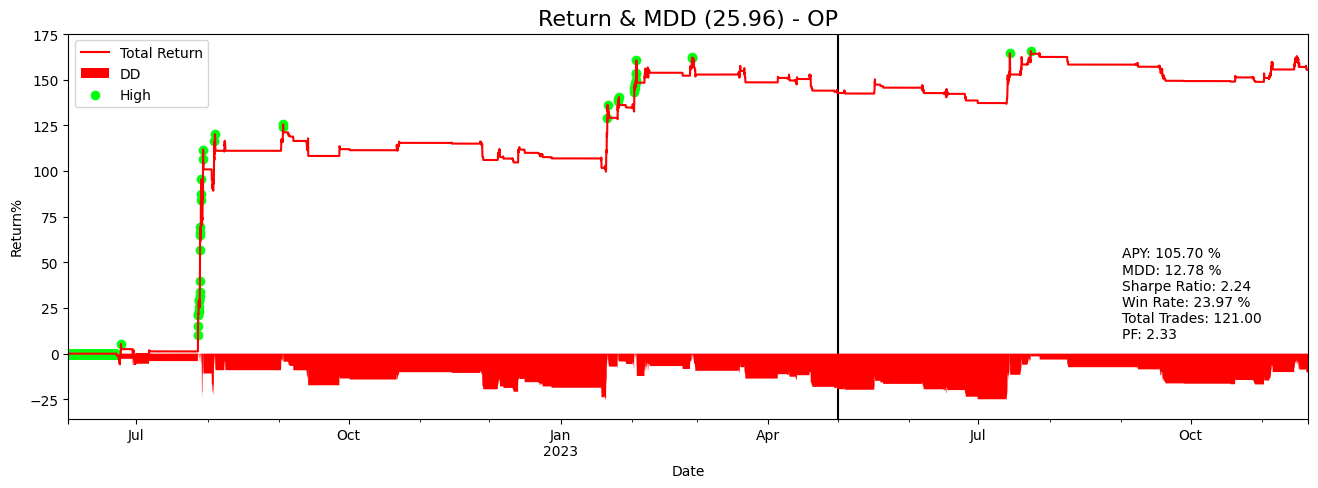

RUNE 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

{'window_size': 72, 'multiplier': 2.5, 'mdd': 31.01, 'sharpe': 2.675808449134239, 'calmar': 4.716128236132478, 'win rate': 35.77981651376147}
APY: 100.66 %
MDD: 16.06 %
MDD Duration 258 days 01:00:00
worst trade: -3.78 %
2022-01-28 00:00:00 ~ 2022-01-28 09:00:00
avg holding days: 0.31 days
--------------------------------------------
PF: 2.40
Sharpe Ratio: 2.68
Calmar Ratio: 4.72
Sortino Ratio: 4.83
Omega Ratio: 1.37
--------------------------------------------
Expectancy : 0.87 %
Total Time Exposure : 9.92 %
Total Trades: 218
Win Rate: 35.78 %
--------------------------------------------
PF * Win Rate: 0.858


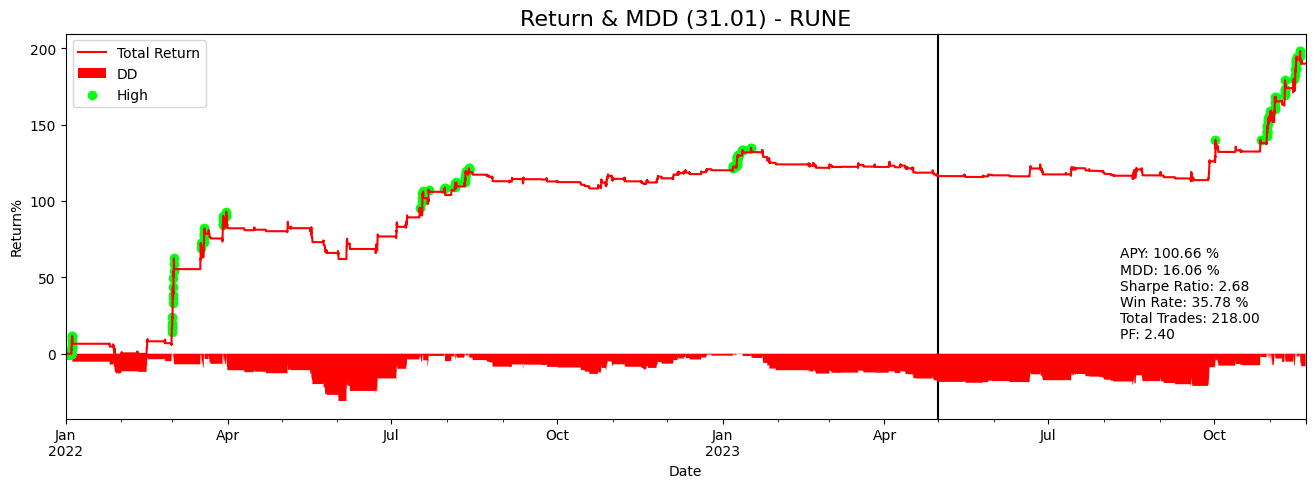

ARB 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

GMT 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

{'window_size': 20, 'multiplier': 2.0, 'mdd': 39.85, 'sharpe': 2.194477169877239, 'calmar': 4.989049691866024, 'win rate': 35.75525812619503}
APY: 143.34 %
MDD: 21.46 %
MDD Duration 150 days 22:00:00
worst trade: -8.92 %
2022-04-21 03:00:00 ~ 2022-04-21 05:00:00
avg holding days: 0.18 days
--------------------------------------------
PF: 1.74
Sharpe Ratio: 2.19
Calmar Ratio: 4.99
Sortino Ratio: 4.35
Omega Ratio: 1.31
--------------------------------------------
Expectancy : 0.46 %
Total Time Exposure : 15.41 %
Total Trades: 523
Win Rate: 35.76 %
--------------------------------------------
PF * Win Rate: 0.621


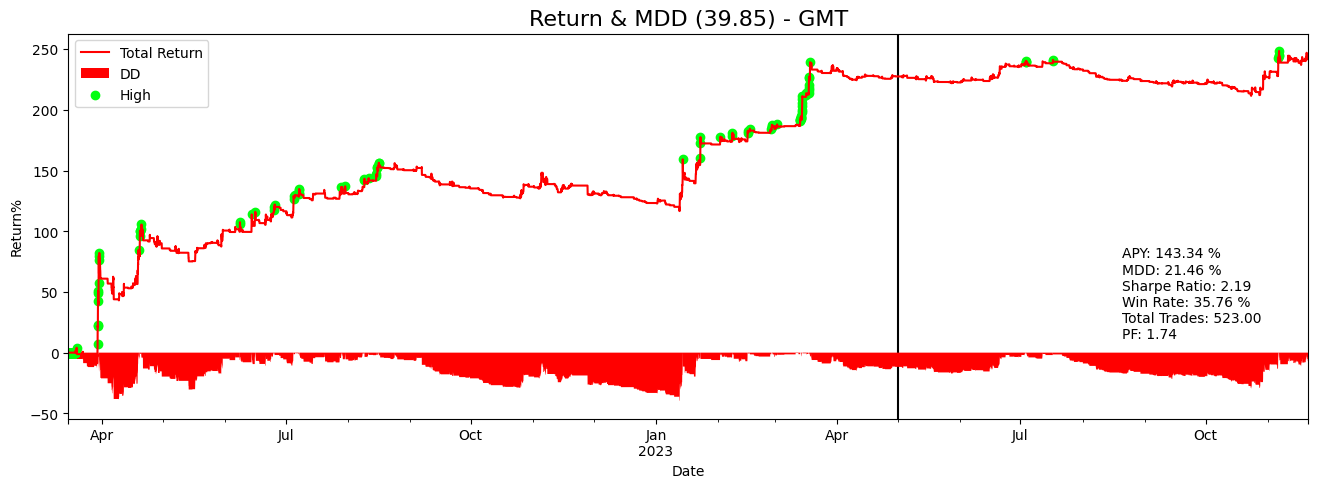

ETC 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

LDO 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

{'window_size': 252, 'multiplier': 2.5, 'mdd': 14.21, 'sharpe': 2.2719793269799613, 'calmar': 7.132956455579776, 'win rate': 31.32530120481928}
APY: 78.29 %
MDD: 10.43 %
MDD Duration 126 days 18:00:00
worst trade: -4.69 %
2023-03-21 13:00:00 ~ 2023-03-21 17:00:00
avg holding days: 0.40 days
--------------------------------------------
PF: 2.40
Sharpe Ratio: 2.27
Calmar Ratio: 7.13
Sortino Ratio: 4.01
Omega Ratio: 1.30
--------------------------------------------
Expectancy : 1.10 %
Total Time Exposure : 7.74 %
Total Trades: 83
Win Rate: 31.33 %
--------------------------------------------
PF * Win Rate: 0.751


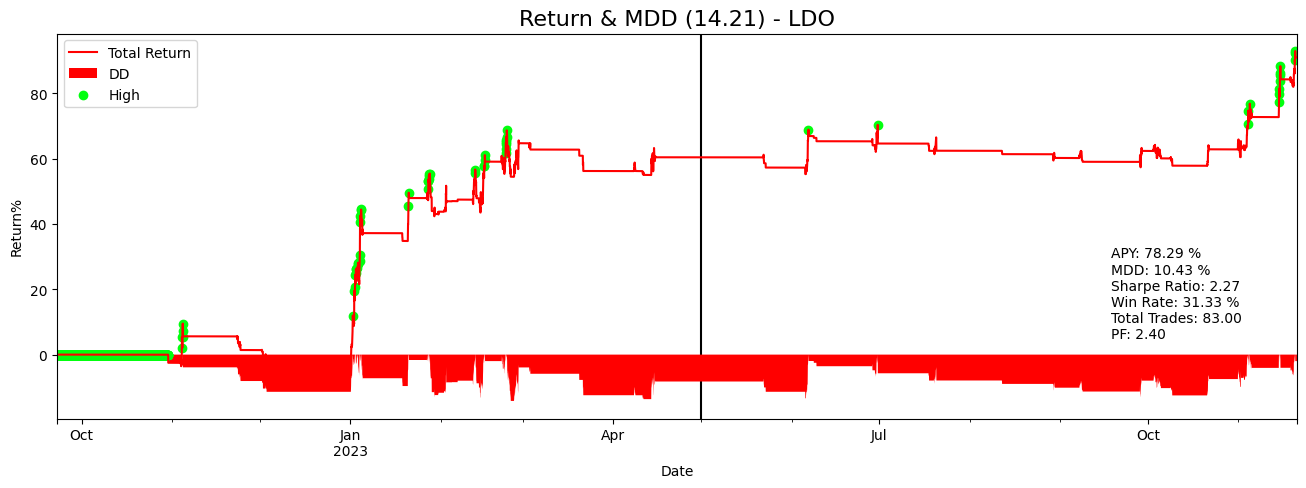

GALA 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

{'window_size': 112, 'multiplier': 2.5, 'mdd': 38.57, 'sharpe': 2.0277713050254667, 'calmar': 3.0258156443450943, 'win rate': 32.71604938271605}
APY: 72.37 %
MDD: 19.10 %
MDD Duration 288 days 17:00:00
worst trade: -5.30 %
2022-09-06 14:00:00 ~ 2022-09-06 17:00:00
avg holding days: 0.38 days
--------------------------------------------
PF: 2.17
Sharpe Ratio: 2.03
Calmar Ratio: 3.03
Sortino Ratio: 3.83
Omega Ratio: 1.31
--------------------------------------------
Expectancy : 0.84 %
Total Time Exposure : 8.99 %
Total Trades: 162
Win Rate: 32.72 %
--------------------------------------------
PF * Win Rate: 0.708


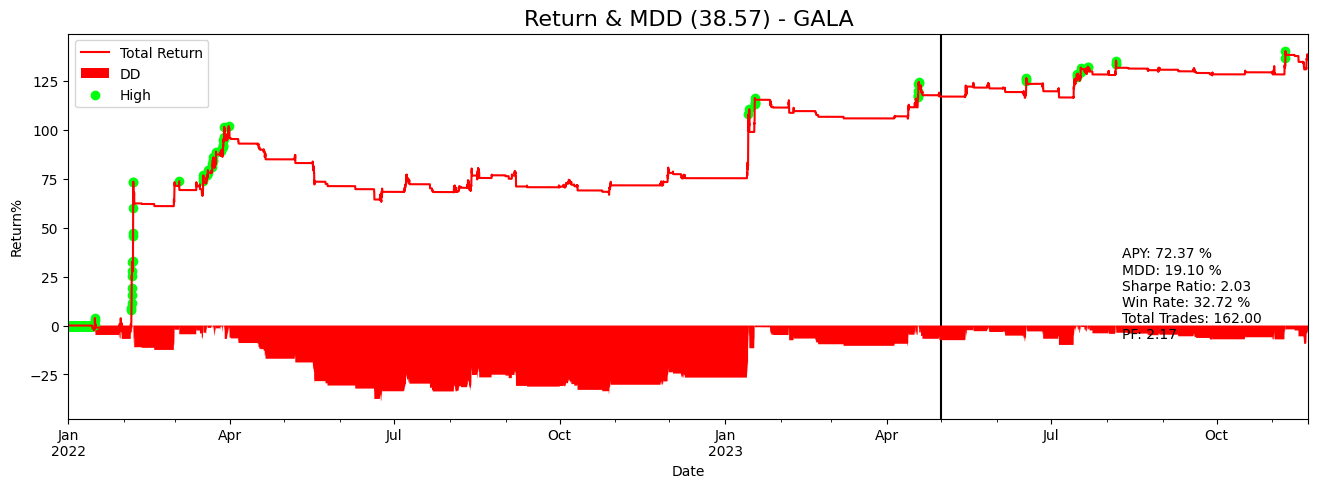

APE 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

APT 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

{'window_size': 148, 'multiplier': 2.5, 'mdd': 37.81, 'sharpe': 2.137857120016542, 'calmar': 5.274657604944461, 'win rate': 20.652173913043477}
APY: 94.60 %
MDD: 17.32 %
MDD Duration 303 days 06:00:00
worst trade: -4.92 %
2023-03-22 23:00:00 ~ 2023-03-23 01:00:00
avg holding days: 0.44 days
--------------------------------------------
PF: 2.45
Sharpe Ratio: 2.14
Calmar Ratio: 5.27
Sortino Ratio: 4.48
Omega Ratio: 1.34
--------------------------------------------
Expectancy : 1.12 %
Total Time Exposure : 10.20 %
Total Trades: 93
Win Rate: 20.65 %
--------------------------------------------
PF * Win Rate: 0.507


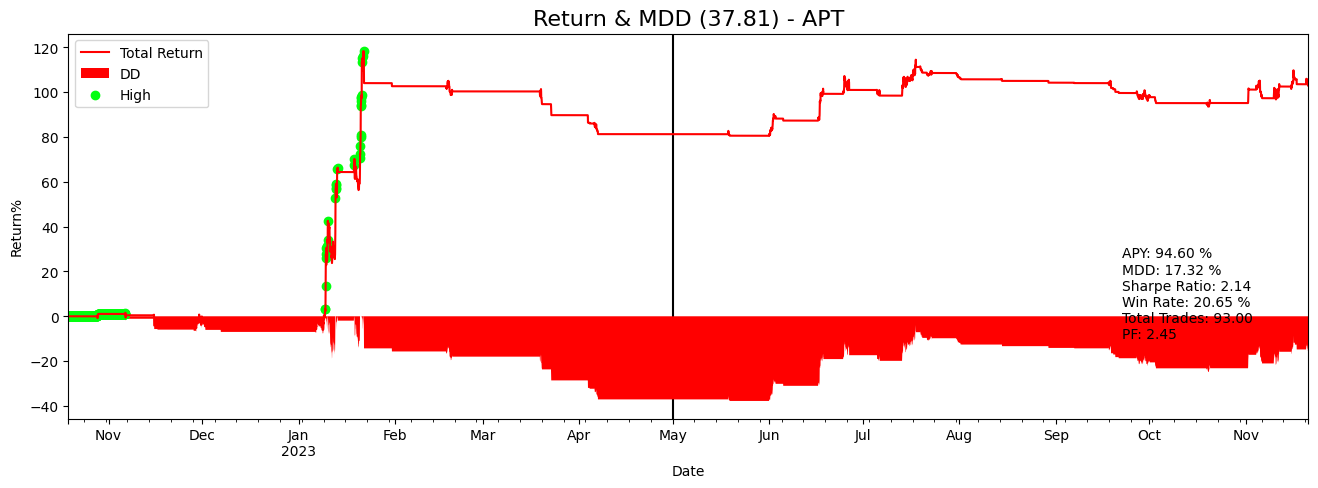

EOS 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

{'window_size': 148, 'multiplier': 2.0, 'mdd': 21.07, 'sharpe': 2.0919017010239025, 'calmar': 4.02432524038484, 'win rate': 29.545454545454547}
APY: 53.22 %
MDD: 11.07 %
MDD Duration 190 days 16:00:00
worst trade: -5.68 %
2023-01-18 14:00:00 ~ 2023-01-18 15:00:00
avg holding days: 0.42 days
--------------------------------------------
PF: 2.00
Sharpe Ratio: 2.09
Calmar Ratio: 4.02
Sortino Ratio: 3.64
Omega Ratio: 1.26
--------------------------------------------
Expectancy : 0.57 %
Total Time Exposure : 10.74 %
Total Trades: 176
Win Rate: 29.55 %
--------------------------------------------
PF * Win Rate: 0.592


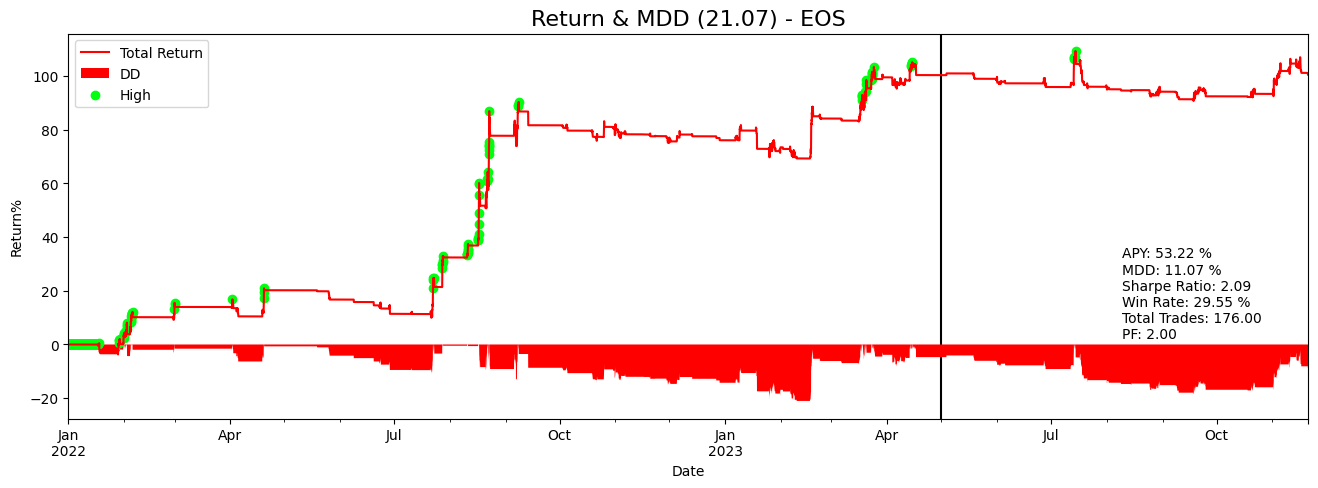

NEAR 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

{'window_size': 188, 'multiplier': 2.0, 'mdd': 19.75, 'sharpe': 2.5542239189028115, 'calmar': 4.529647337822648, 'win rate': 35.3448275862069}
APY: 70.57 %
MDD: 12.50 %
MDD Duration 132 days 14:00:00
worst trade: -2.95 %
2022-01-31 16:00:00 ~ 2022-01-31 19:00:00
avg holding days: 0.43 days
--------------------------------------------
PF: 2.88
Sharpe Ratio: 2.55
Calmar Ratio: 4.53
Sortino Ratio: 4.56
Omega Ratio: 1.36
--------------------------------------------
Expectancy : 1.15 %
Total Time Exposure : 7.30 %
Total Trades: 116
Win Rate: 35.34 %
--------------------------------------------
PF * Win Rate: 1.019


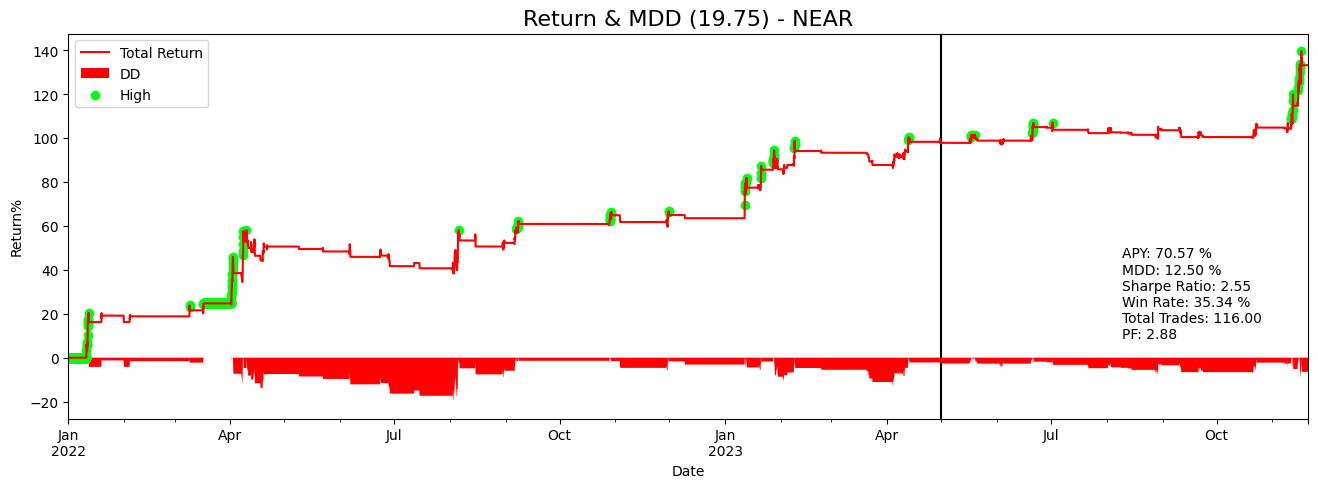

BLUR 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

{'window_size': 132, 'multiplier': 2.0, 'mdd': 22.01, 'sharpe': 2.3471323466888787, 'calmar': 8.139422825813556, 'win rate': 26.08695652173913}
APY: 113.07 %
MDD: 17.10 %
MDD Duration 113 days 07:00:00
worst trade: -3.18 %
2023-11-20 16:00:00 ~ 2023-11-20 18:00:00
avg holding days: 0.38 days
--------------------------------------------
PF: 2.91
Sharpe Ratio: 2.35
Calmar Ratio: 8.14
Sortino Ratio: 4.15
Omega Ratio: 1.34
--------------------------------------------
Expectancy : 1.39 %
Total Time Exposure : 8.55 %
Total Trades: 46
Win Rate: 26.09 %
--------------------------------------------
PF * Win Rate: 0.758


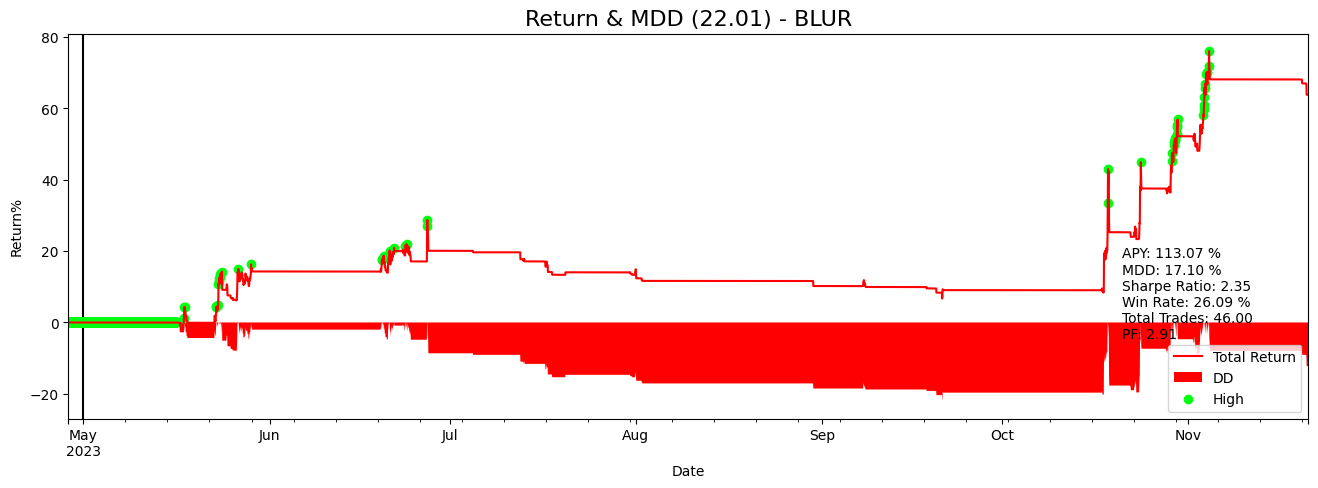

WAVES 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

NEO 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

FET 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

{'window_size': 228, 'multiplier': 2.0, 'mdd': 36.19, 'sharpe': 2.7695747720359414, 'calmar': 11.483478103882911, 'win rate': 26.08695652173913}
APY: 159.40 %
MDD: 15.15 %
MDD Duration 151 days 15:00:00
worst trade: -5.21 %
2023-06-30 03:00:00 ~ 2023-06-30 13:00:00
avg holding days: 0.46 days
--------------------------------------------
PF: 3.55
Sharpe Ratio: 2.77
Calmar Ratio: 11.48
Sortino Ratio: 5.32
Omega Ratio: 1.39
--------------------------------------------
Expectancy : 1.94 %
Total Time Exposure : 10.32 %
Total Trades: 69
Win Rate: 26.09 %
--------------------------------------------
PF * Win Rate: 0.925


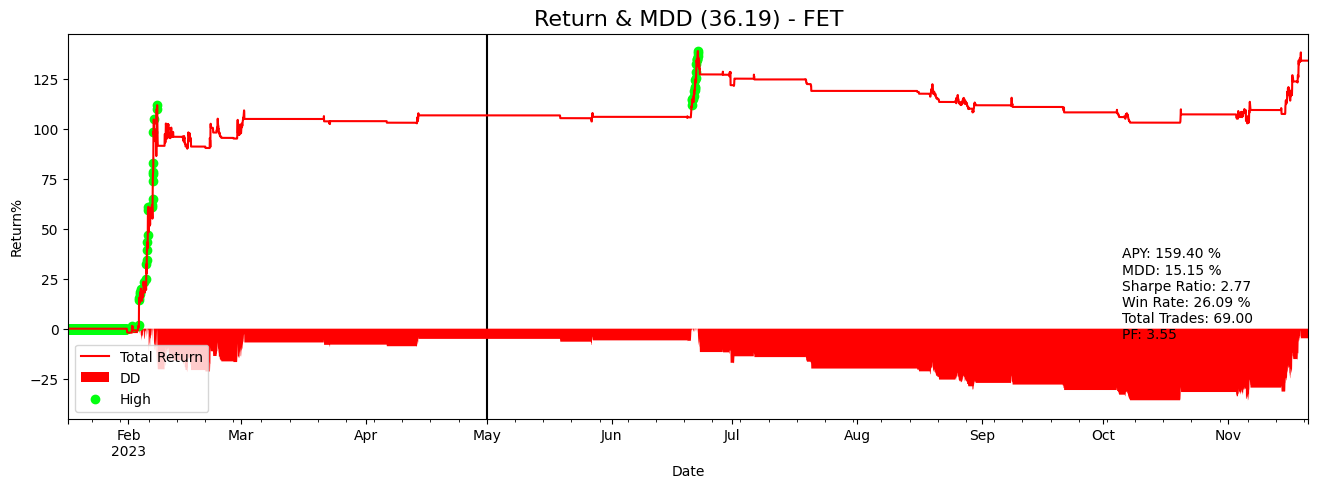

GRT 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

STX 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

BTC 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

{'window_size': 308, 'multiplier': 2.5, 'mdd': 6.53, 'sharpe': 2.253657720375353, 'calmar': 6.976929910414635, 'win rate': 50.0}
APY: 30.96 %
MDD: 3.96 %
MDD Duration 211 days 12:00:00
worst trade: -1.37 %
2023-08-01 20:00:00 ~ 2023-08-02 12:00:00
avg holding days: 5.27 days
--------------------------------------------
PF: 22.47
Sharpe Ratio: 2.25
Calmar Ratio: 6.98
Sortino Ratio: 5.02
Omega Ratio: 1.80
--------------------------------------------
Expectancy : 5.84 %
Total Time Exposure : 7.64 %
Total Trades: 10
Win Rate: 50.00 %
--------------------------------------------
PF * Win Rate: 11.235


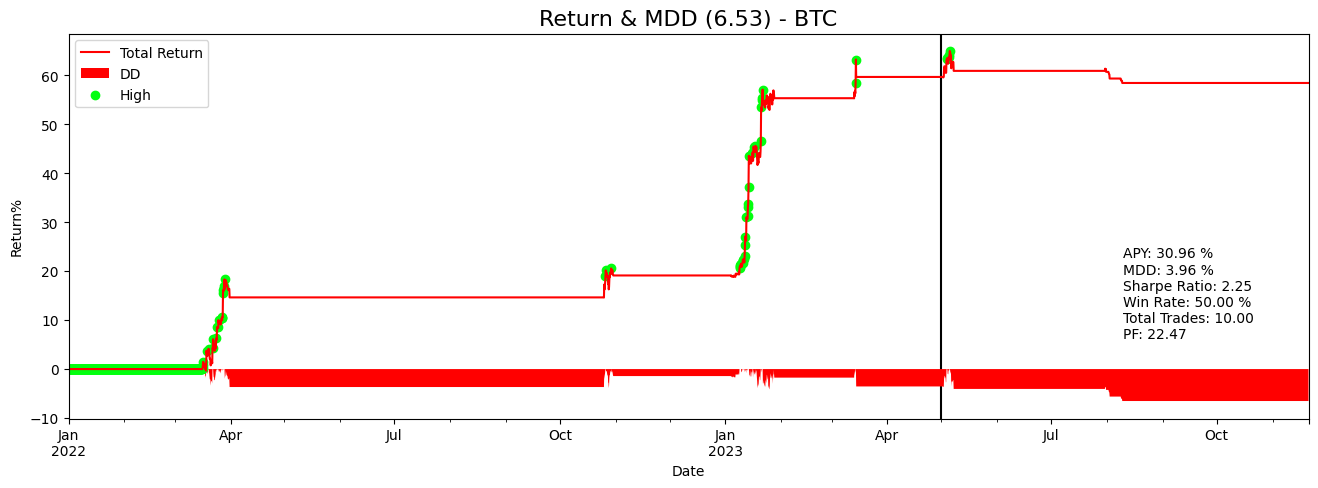

OP 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

ARB 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

GMT 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

{'window_size': 32, 'multiplier': 2.0, 'mdd': 94.26, 'sharpe': 2.112320964042325, 'calmar': 5.389243414694496, 'win rate': 40.243902439024396}
APY: 179.03 %
MDD: 23.74 %
MDD Duration 299 days 04:00:00
worst trade: -9.49 %
2022-11-08 08:00:00 ~ 2022-11-08 16:00:00
avg holding days: 0.93 days
--------------------------------------------
PF: 3.74
Sharpe Ratio: 2.11
Calmar Ratio: 5.39
Sortino Ratio: 5.05
Omega Ratio: 1.88
--------------------------------------------
Expectancy : 3.68 %
Total Time Exposure : 12.34 %
Total Trades: 82
Win Rate: 40.24 %
--------------------------------------------
PF * Win Rate: 1.504


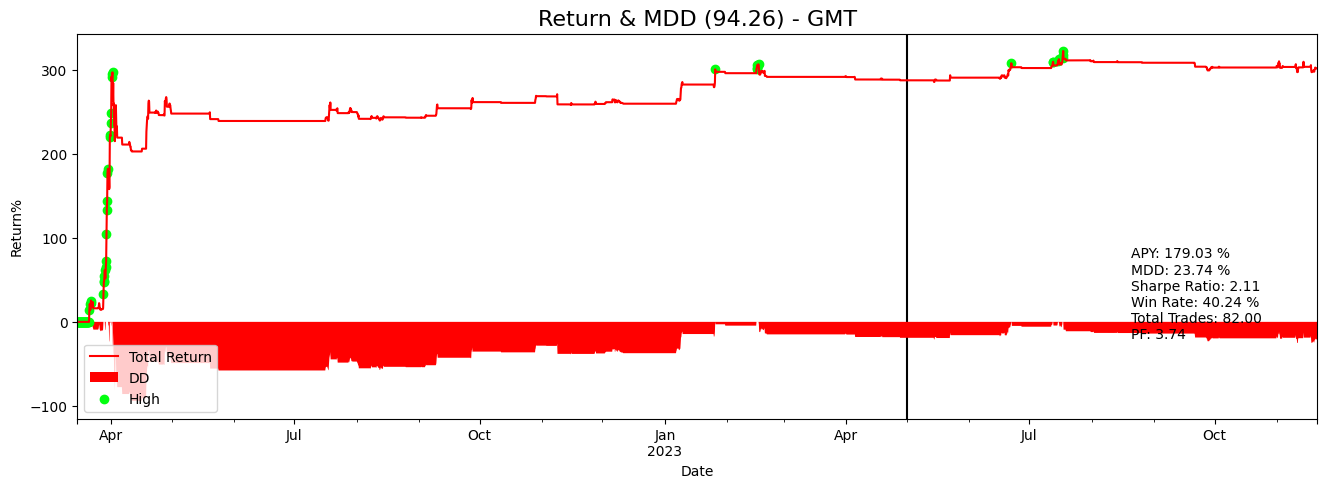

LDO 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

INJ 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

{'window_size': 128, 'multiplier': 2.0, 'mdd': 25.05, 'sharpe': 2.528171067317998, 'calmar': 8.67892622382369, 'win rate': 43.333333333333336}
APY: 126.40 %
MDD: 13.00 %
MDD Duration 172 days 04:00:00
worst trade: -9.98 %
2023-03-02 20:00:00 ~ 2023-03-03 00:00:00
avg holding days: 1.93 days
--------------------------------------------
PF: 5.38
Sharpe Ratio: 2.53
Calmar Ratio: 8.68
Sortino Ratio: 4.61
Omega Ratio: 1.62
--------------------------------------------
Expectancy : 5.32 %
Total Time Exposure : 12.58 %
Total Trades: 30
Win Rate: 43.33 %
--------------------------------------------
PF * Win Rate: 2.330


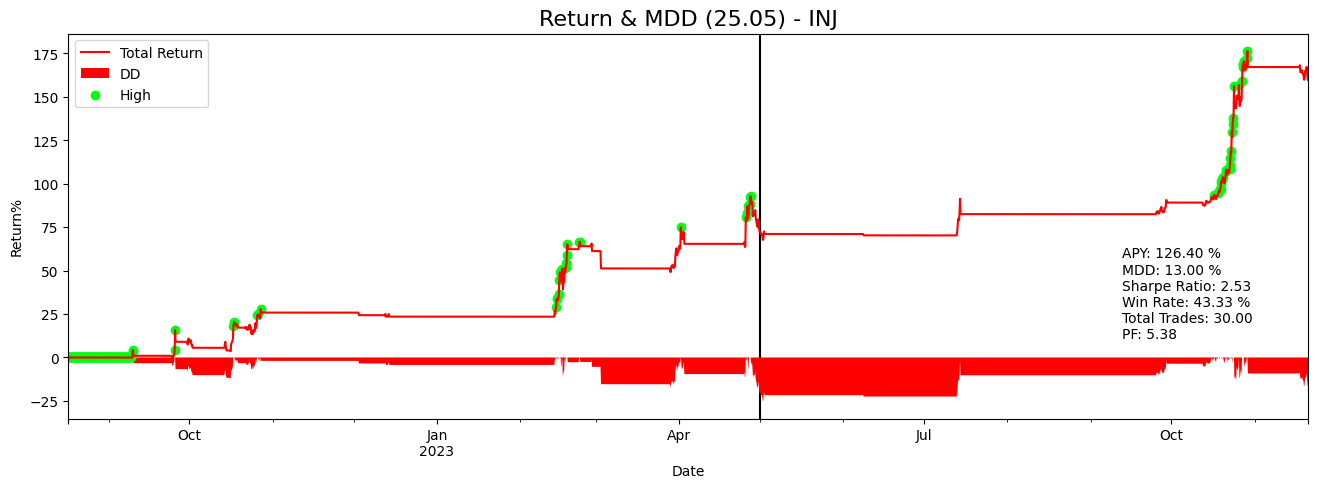

APT 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

{'window_size': 40, 'multiplier': 2.0, 'mdd': 36.41, 'sharpe': 2.119948641486128, 'calmar': 5.944797979391226, 'win rate': 38.775510204081634}
APY: 95.81 %
MDD: 15.58 %
MDD Duration 303 days 08:00:00
worst trade: -6.58 %
2023-11-01 16:00:00 ~ 2023-11-02 12:00:00
avg holding days: 1.01 days
--------------------------------------------
PF: 2.92
Sharpe Ratio: 2.12
Calmar Ratio: 5.94
Sortino Ratio: 5.08
Omega Ratio: 1.67
--------------------------------------------
Expectancy : 2.13 %
Total Time Exposure : 12.47 %
Total Trades: 49
Win Rate: 38.78 %
--------------------------------------------
PF * Win Rate: 1.134


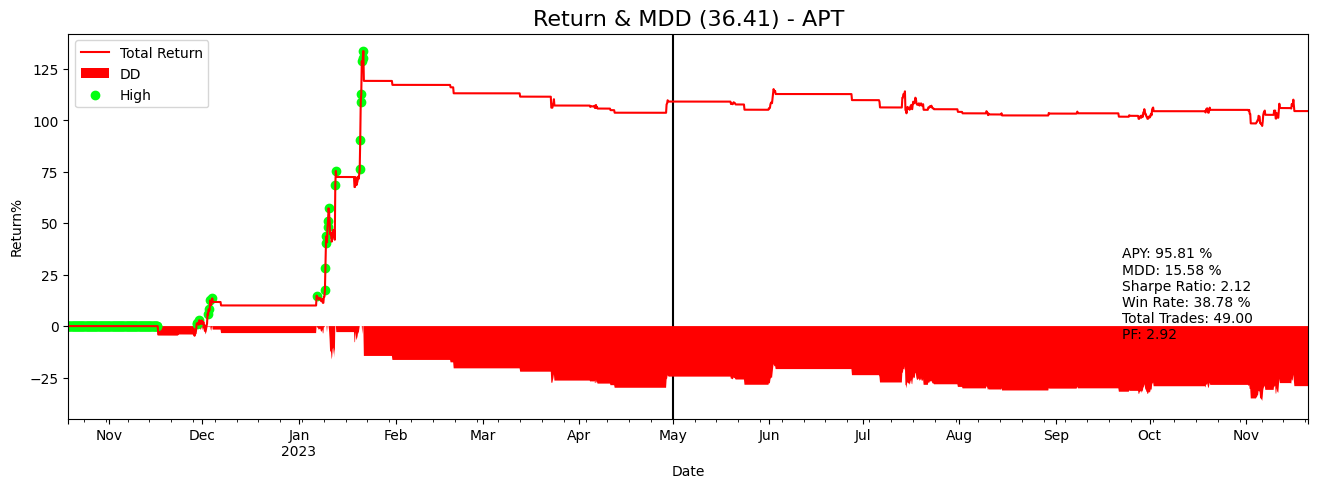

SUSHI 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

{'window_size': 152, 'multiplier': 2.0, 'mdd': 14.78, 'sharpe': 2.0983899457913453, 'calmar': 6.284043960224088, 'win rate': 48.0}
APY: 66.75 %
MDD: 8.59 %
MDD Duration 163 days 12:00:00
worst trade: -3.28 %
2023-02-15 16:00:00 ~ 2023-02-16 20:00:00
avg holding days: 1.93 days
--------------------------------------------
PF: 8.59
Sharpe Ratio: 2.10
Calmar Ratio: 6.28
Sortino Ratio: 4.09
Omega Ratio: 1.70
--------------------------------------------
Expectancy : 5.04 %
Total Time Exposure : 7.01 %
Total Trades: 25
Win Rate: 48.00 %
--------------------------------------------
PF * Win Rate: 4.122


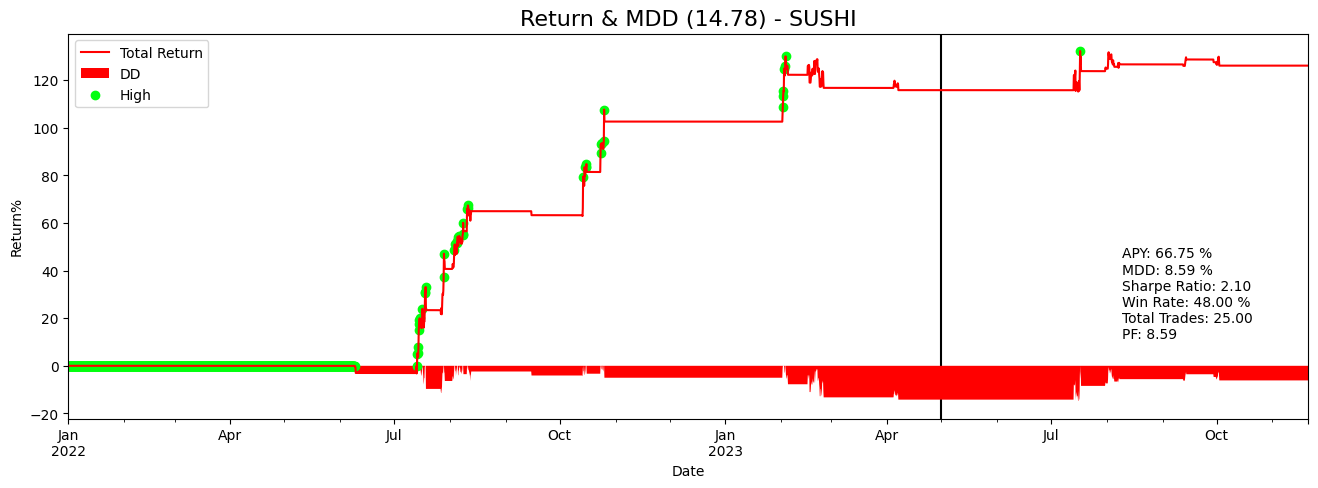

FET 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

{'window_size': 56, 'multiplier': 2.5, 'mdd': 31.85, 'sharpe': 2.377173691324764, 'calmar': 10.278000334832573, 'win rate': 37.83783783783784}
APY: 146.13 %
MDD: 15.47 %
MDD Duration 150 days 08:00:00
worst trade: -8.47 %
2023-02-28 00:00:00 ~ 2023-02-28 04:00:00
avg holding days: 1.18 days
--------------------------------------------
PF: 3.06
Sharpe Ratio: 2.38
Calmar Ratio: 10.28
Sortino Ratio: 5.12
Omega Ratio: 1.61
--------------------------------------------
Expectancy : 3.33 %
Total Time Exposure : 14.17 %
Total Trades: 37
Win Rate: 37.84 %
--------------------------------------------
PF * Win Rate: 1.159


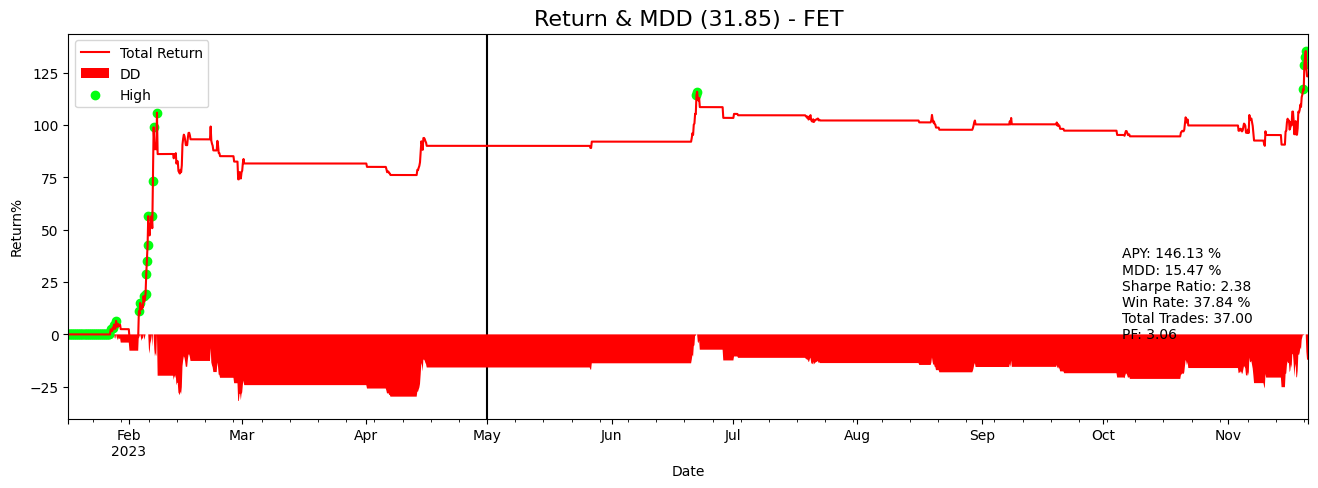

GRT 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

STX 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

In [11]:
for freq in insample_long_dict.keys():
    for coin in insample_long_dict[freq]:
        print(coin, freq)
        in_out_test(freq,coin,'long')

In [12]:
import hiplot as hip
freq = '15T'
for direction in ['long','short']:
    print(f'-------------------------frequency:{freq}----------------------direction:{direction}---------------------')
    outample_params_highland('15T', direction, 'AVAX')


-------------------------frequency:15T----------------------direction:long---------------------


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

-------------------------frequency:15T----------------------direction:short---------------------


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

KeyboardInterrupt: 

### 挑選參數全樣本結果

APY: 128.45 %
MDD: 15.98 %
MDD Duration 95 days 01:00:00
worst trade: -10.75 %
2022-09-07 04:00:00 ~ 2022-09-09 03:00:00
avg holding days: 5.29 days
--------------------------------------------
PF: 2.64
Sharpe Ratio: 2.16
Calmar Ratio: 5.79
Sortino Ratio: 3.26
Omega Ratio: 1.10
--------------------------------------------
Expectancy : 2.47 %
Total Time Exposure : 75.38 %
Total Trades: 97
Win Rate: 52.58 %
--------------------------------------------
PF * Win Rate: 1.385


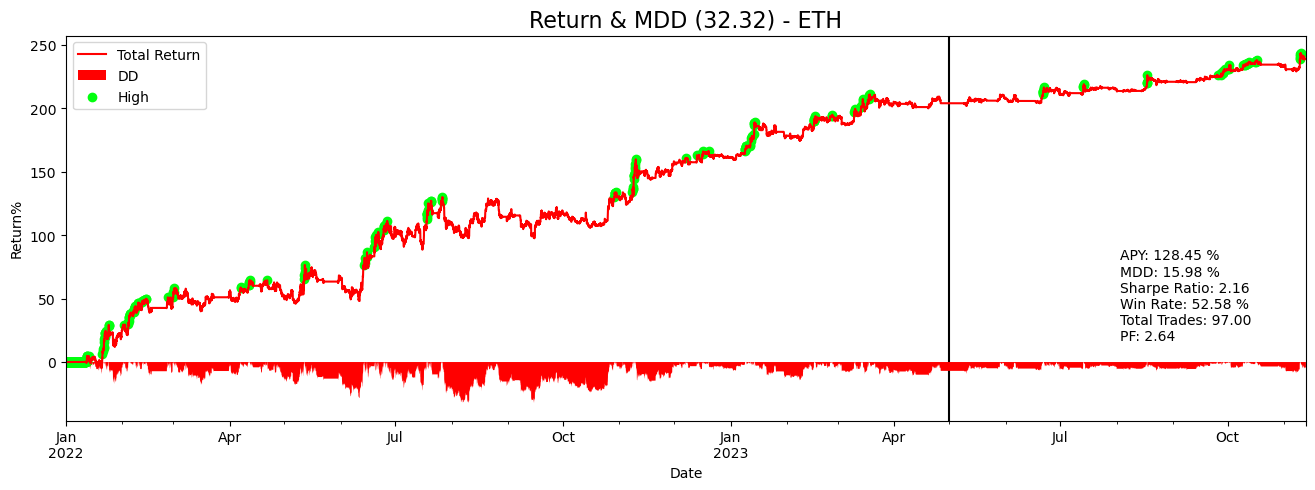

(None,
 Start                               2022-01-01 00:00:00
 End                                 2023-11-12 23:00:00
 Period                                681 days 00:00:00
 Start Value                                     10000.0
 Min Value                                   9524.910264
 Max Value                                  34363.056868
 End Value                                  33929.683914
 Total Return [%]                             239.296839
 Benchmark Return [%]                         -44.573538
 Total Time Exposure [%]                       75.379344
 Max Gross Exposure [%]                        108.13714
 Max Drawdown [%]                              15.981857
 Max Drawdown Duration                  95 days 01:00:00
 Total Orders                                        185
 Total Fees Paid                              582.121873
 Total Trades                                         97
 Win Rate [%]                                   52.57732
 Best Trade [%]         

In [3]:
start = '2022-01-01'
sep = ''
end = ''

side = 'both'

params = {'window_l_k': 48, 'window_l_d': 132, 'window_s_k': 52, 'window_s_d': 140}
# sol 1h : 40,48,100,126,95 original
config = {'freq':'1h', 'lag':1, 'fee': 0.0003}
coin = 'ETH'
df = df_dict[coin]
strategy = Strategy(df=df.loc[start:], configs=config)
_pf = strategy.strategy(side = side,params=params)
trades = _pf.trades.records_readable
analyze = Analyzer(strategy)
analyze.show_pf_analysis(params, side, coin, axv_index=['2023-05-01'])